In [1]:
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

# Load the dataset
data = pd.read_csv("Courses.csv")

In [19]:
import numpy as np

# 1. Remove specified columns
columns_to_remove = ['nplay_video', 'incomplete_flag', 'roles']
df_cleaned = data.drop(columns=columns_to_remove)

# 2. Handle missing values
# For categorical variables (LoE_DI) - impute with mode
df_cleaned['LoE_DI'] = df_cleaned['LoE_DI'].fillna(df_cleaned['LoE_DI'].mode()[0])
# For gender in random way
missing_indices = df_cleaned[data['gender'].isnull()].index
df_cleaned.loc[missing_indices, 'gender'] = np.random.choice(data['gender'].dropna(), len(missing_indices))

# For YoB - impute with median
df_cleaned['YoB'] = df_cleaned['YoB'].fillna(df_cleaned['YoB'].median())

# 3. Drop rows with missing grades, 7%
df_cleaned = df_cleaned.dropna(subset=['grade'])


# 4. Save the cleaned dataset
df_cleaned.to_csv('cleaned_dataset.csv', index=False)

# Print summary of the changes
print("Original dataset shape:", data.shape)
print("Cleaned dataset shape:", df_cleaned.shape)
print("\nMissing values in cleaned dataset:")
print(df_cleaned.isnull().sum())

Original dataset shape: (641138, 20)
Cleaned dataset shape: (592766, 17)

Missing values in cleaned dataset:
course_id                 0
userid_DI                 0
registered                0
viewed                    0
explored                  0
certified                 0
final_cc_cname_DI         0
LoE_DI                    0
YoB                       0
gender                    0
grade                     0
start_time_DI             0
last_event_DI        169903
nevents              188443
ndays_act            156092
nchapters            236771
nforum_posts              0
dtype: int64


Verification of imputation:

Missing values in original column: 236771
Missing values in imputed column: 92698

Summary statistics of imputed column:
count    500068.000000
mean          2.939204
std           4.036424
min           1.000000
25%           1.000000
50%           1.000000
75%           3.000000
max          48.000000
Name: nchapters_imputed, dtype: float64


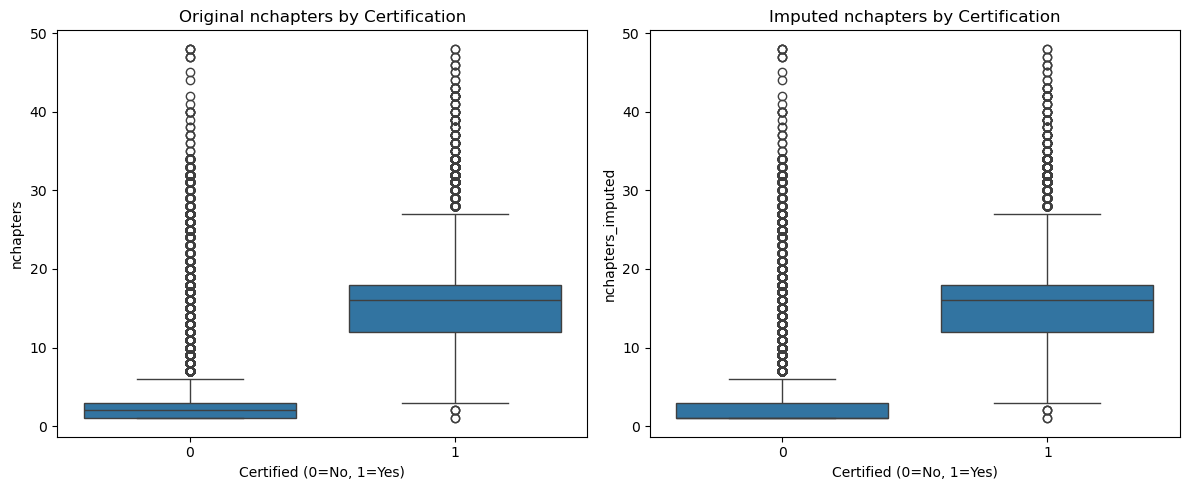

In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def impute_nchapters_simple(df):
    # Create copy of original nchapters
    df['nchapters_imputed'] = df['nchapters'].copy()
    
    # Imputation logic based on certification and activity days
    mask = df['nchapters'].isna()
    
    conditions = [
        # Condition 1: Certified students (though we saw none in missing values)
        (mask) & (df['certified'] == 1),
        # Condition 2: Not certified but active (ndays_act > 3)
        (mask) & (df['certified'] == 0) & (df['ndays_act'] > 3),
        # Condition 3: Not certified and minimal activity
        (mask) & (df['certified'] == 0) & (df['ndays_act'] <= 3)
    ]
    
    # Values based on our analysis
    values = [
        16,  # Average for certified students
        3,   # Average for non-certified students
        1    # Minimal engagement for low activity
    ]
    
    # Apply imputation
    df['nchapters_imputed'] = np.select(conditions, values, df['nchapters_imputed'])
    
    return df['nchapters_imputed']

# Apply imputation to df_cleaned directly
df_cleaned['nchapters_imputed'] = impute_nchapters_simple(df_cleaned)

# Verify results
print("Verification of imputation:")
print("\nMissing values in original column:", df_cleaned['nchapters'].isna().sum())
print("Missing values in imputed column:", df_cleaned['nchapters_imputed'].isna().sum())
print("\nSummary statistics of imputed column:")
print(df_cleaned['nchapters_imputed'].describe())

# Compare distributions
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.boxplot(x='certified', y='nchapters', data=df_cleaned)
plt.title('Original nchapters by Certification')
plt.xlabel('Certified (0=No, 1=Yes)')

plt.subplot(1, 2, 2)
sns.boxplot(x='certified', y='nchapters_imputed', data=df_cleaned)
plt.title('Imputed nchapters by Certification')
plt.xlabel('Certified (0=No, 1=Yes)')

plt.tight_layout()
plt.show()


In [25]:
import numpy as np
import pandas as pd

# First, let's create the imputation function
def impute_nevents(row):
    if pd.isna(row['nevents']):  # Only impute if the value is missing
        if row['nchapters'] == 0:
            return 0
        elif row['nchapters'] == 1:
            return np.random.choice([0, 1], p=[0.7, 0.3])
        elif 2 <= row['nchapters'] <= 5:
            return np.random.choice([0, 1, 2], p=[0.5, 0.3, 0.2])
        elif 6 <= row['nchapters'] <= 12:
            return np.random.choice([1, 2, 3], p=[0.4, 0.4, 0.2])
        else:
            return np.random.choice([2, 3, 4], p=[0.3, 0.4, 0.3])
    else:
        return row['nevents']  # Return original value if not missing

# Set random seed for reproducibility
np.random.seed(42)

# Create new column with imputed values
df_cleaned['nevents_imputed'] = df_cleaned.apply(impute_nevents, axis=1)

# Let's verify the imputation
print("\nVerification of imputation:")
print("Original missing values:", df_cleaned['nevents'].isna().sum())
print("New missing values:", df_cleaned['nevents_imputed'].isna().sum())

# Show distribution of original vs imputed values
print("\nDistribution of original nevents (excluding missing):")
print(df_cleaned['nevents'].value_counts(normalize=True).head())
print("\nDistribution of imputed nevents:")
print(df_cleaned['nevents_imputed'].value_counts(normalize=True).head())



Verification of imputation:
Original missing values: 188443
New missing values: 0

Distribution of original nevents (excluding missing):
nevents
1.0    0.143989
2.0    0.078489
3.0    0.039760
4.0    0.027127
5.0    0.021762
Name: proportion, dtype: float64

Distribution of imputed nevents:
nevents_imputed
1.0    0.134932
2.0    0.122468
3.0    0.106875
4.0    0.077714
0.0    0.073290
Name: proportion, dtype: float64


In [29]:
print(df_cleaned.isnull().sum())
print(df_cleaned.isnull().mean() * 100)

course_id                 0
userid_DI                 0
registered                0
viewed                    0
explored                  0
certified                 0
final_cc_cname_DI         0
LoE_DI                    0
YoB                       0
gender                    0
grade                     0
start_time_DI             0
last_event_DI        169903
nevents              188443
ndays_act            156092
nchapters            236771
nforum_posts              0
nchapters_imputed     92698
nevents_imputed           0
dtype: int64
course_id             0.000000
userid_DI             0.000000
registered            0.000000
viewed                0.000000
explored              0.000000
certified             0.000000
final_cc_cname_DI     0.000000
LoE_DI                0.000000
YoB                   0.000000
gender                0.000000
grade                 0.000000
start_time_DI         0.000000
last_event_DI        28.662744
nevents              31.790454
ndays_act            

In [31]:
def analyze_missing_cases(df):
    # Get rows with missing values after imputation
    missing_after = df[df['nchapters_imputed'].isna()]
    
    print("Analysis of remaining missing values:")
    print(f"\nTotal rows with missing values: {len(missing_after)}")
    print("\nDistribution of certified status in missing rows:")
    print(missing_after['certified'].value_counts(normalize=True))
    print("\nSummary of ndays_act for missing rows:")
    print(missing_after['ndays_act'].describe())
    
    # Check if our conditions missed any cases
    print("\nChecking conditions coverage:")
    mask = df['nchapters'].isna()
    not_covered = mask & ~(
        ((df['certified'] == 1)) |
        ((df['certified'] == 0) & (df['ndays_act'] > 3)) |
        ((df['certified'] == 0) & (df['ndays_act'] <= 3))
    )
    print(f"\nRows not covered by any condition: {not_covered.sum()}")
    
    if not_covered.sum() > 0:
        print("\nSample of uncovered cases:")
        print(df[not_covered].head())

# Modified imputation function with more detailed logging
def impute_nchapters_simple_v2(df):
    # Create copy of original nchapters
    df['nchapters_imputed'] = df['nchapters'].copy()
    
    # Imputation logic based on certification and activity days
    mask = df['nchapters'].isna()
    
    conditions = [
        # Condition 1: Certified students
        (mask) & (df['certified'] == 1),
        # Condition 2: Not certified but active (ndays_act > 3)
        (mask) & (df['certified'] == 0) & (df['ndays_act'] > 3),
        # Condition 3: Not certified and minimal activity
        (mask) & (df['certified'] == 0) & (df['ndays_act'] <= 3)
    ]
    
    values = [16, 3, 1]
    
    # Apply imputation
    df['nchapters_imputed'] = np.select(conditions, values, df['nchapters_imputed'])
    
    print("Imputation summary:")
    print(f"Original missing values: {mask.sum()}")
    print(f"Values imputed: {mask.sum() - df['nchapters_imputed'].isna().sum()}")
    print(f"Remaining missing values: {df['nchapters_imputed'].isna().sum()}")
    
    return df['nchapters_imputed']

# Apply the new imputation and analyze results
df_cleaned['nchapters_imputed'] = impute_nchapters_simple_v2(df_cleaned)
analyze_missing_cases(df_cleaned)

# Check for any unexpected values in certified or ndays_act
print("\nChecking for unexpected values:")
print("\nUnique values in certified column:")
print(df_cleaned['certified'].unique())
print("\nRange of ndays_act:")
print(df_cleaned['ndays_act'].describe())


Imputation summary:
Original missing values: 236771
Values imputed: 144073
Remaining missing values: 92698
Analysis of remaining missing values:

Total rows with missing values: 92698

Distribution of certified status in missing rows:
certified
0    1.0
Name: proportion, dtype: float64

Summary of ndays_act for missing rows:
count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: ndays_act, dtype: float64

Checking conditions coverage:

Rows not covered by any condition: 92698

Sample of uncovered cases:
                     course_id       userid_DI  registered  viewed  explored  \
25         HarvardX/CS50x/2012  MHxPC130506580           1       0         0   
31  HarvardX/CB22x/2013_Spring  MHxPC130148402           1       0         0   
32  HarvardX/ER22x/2013_Spring  MHxPC130148402           1       0         0   
35         HarvardX/CS50x/2012  MHxPC130003498           1       0         0   
40         HarvardX/CS50x/2012  MHxP

In [33]:
# 1. First define the new function
def impute_nchapters_simple_v3(df):
    # Create copy of original nchapters
    df['nchapters_imputed'] = df['nchapters'].copy()
    
    # Imputation logic based on certification and activity days
    mask = df['nchapters'].isna()
    
    conditions = [
        # Condition 1: Certified students
        (mask) & (df['certified'] == 1),
        # Condition 2: Not certified but active (ndays_act > 3)
        (mask) & (df['certified'] == 0) & (df['ndays_act'] > 3),
        # Condition 3: Not certified and some activity (ndays_act <= 3)
        (mask) & (df['certified'] == 0) & (df['ndays_act'] <= 3),
        # Condition 4: No activity recorded (ndays_act is NaN) but viewed course
        (mask) & (df['ndays_act'].isna()) & (df['viewed'] == 1),
        # Condition 5: No activity and never viewed (complete non-engagement)
        (mask) & (df['ndays_act'].isna()) & (df['viewed'] == 0)
    ]
    
    values = [
        16,  # Average for certified students
        3,   # Average for non-certified active students
        1,   # Minimal engagement
        1,   # Viewed but no sustained activity
        0    # Never engaged with content
    ]
    
    # Apply imputation
    df['nchapters_imputed'] = np.select(conditions, values, df['nchapters_imputed'])
    
    return df['nchapters_imputed']

# 2. Then use it in your pipeline
df_cleaned['nchapters_imputed'] = impute_nchapters_simple_v3(df_cleaned)

# 3. Verify there are no missing values
print("Missing values after imputation:", df_cleaned['nchapters_imputed'].isna().sum())


Missing values after imputation: 0


In [35]:
print(df_cleaned.isnull().mean() * 100)

course_id             0.000000
userid_DI             0.000000
registered            0.000000
viewed                0.000000
explored              0.000000
certified             0.000000
final_cc_cname_DI     0.000000
LoE_DI                0.000000
YoB                   0.000000
gender                0.000000
grade                 0.000000
start_time_DI         0.000000
last_event_DI        28.662744
nevents              31.790454
ndays_act            26.332819
nchapters            39.943418
nforum_posts          0.000000
nchapters_imputed     0.000000
nevents_imputed       0.000000
dtype: float64


Dataset Overview:
--------------------------------------------------

Shape: (592766, 19)

Columns: ['course_id', 'userid_DI', 'registered', 'viewed', 'explored', 'certified', 'final_cc_cname_DI', 'LoE_DI', 'YoB', 'gender', 'grade', 'start_time_DI', 'last_event_DI', 'nevents', 'ndays_act', 'nchapters', 'nforum_posts', 'nchapters_imputed', 'nevents_imputed']

Missing Values Analysis:
--------------------------------------------------
               Missing Values  Percentage
nchapters              236771   39.943418
nevents                188443   31.790454
last_event_DI          169903   28.662744
ndays_act              156092   26.332819


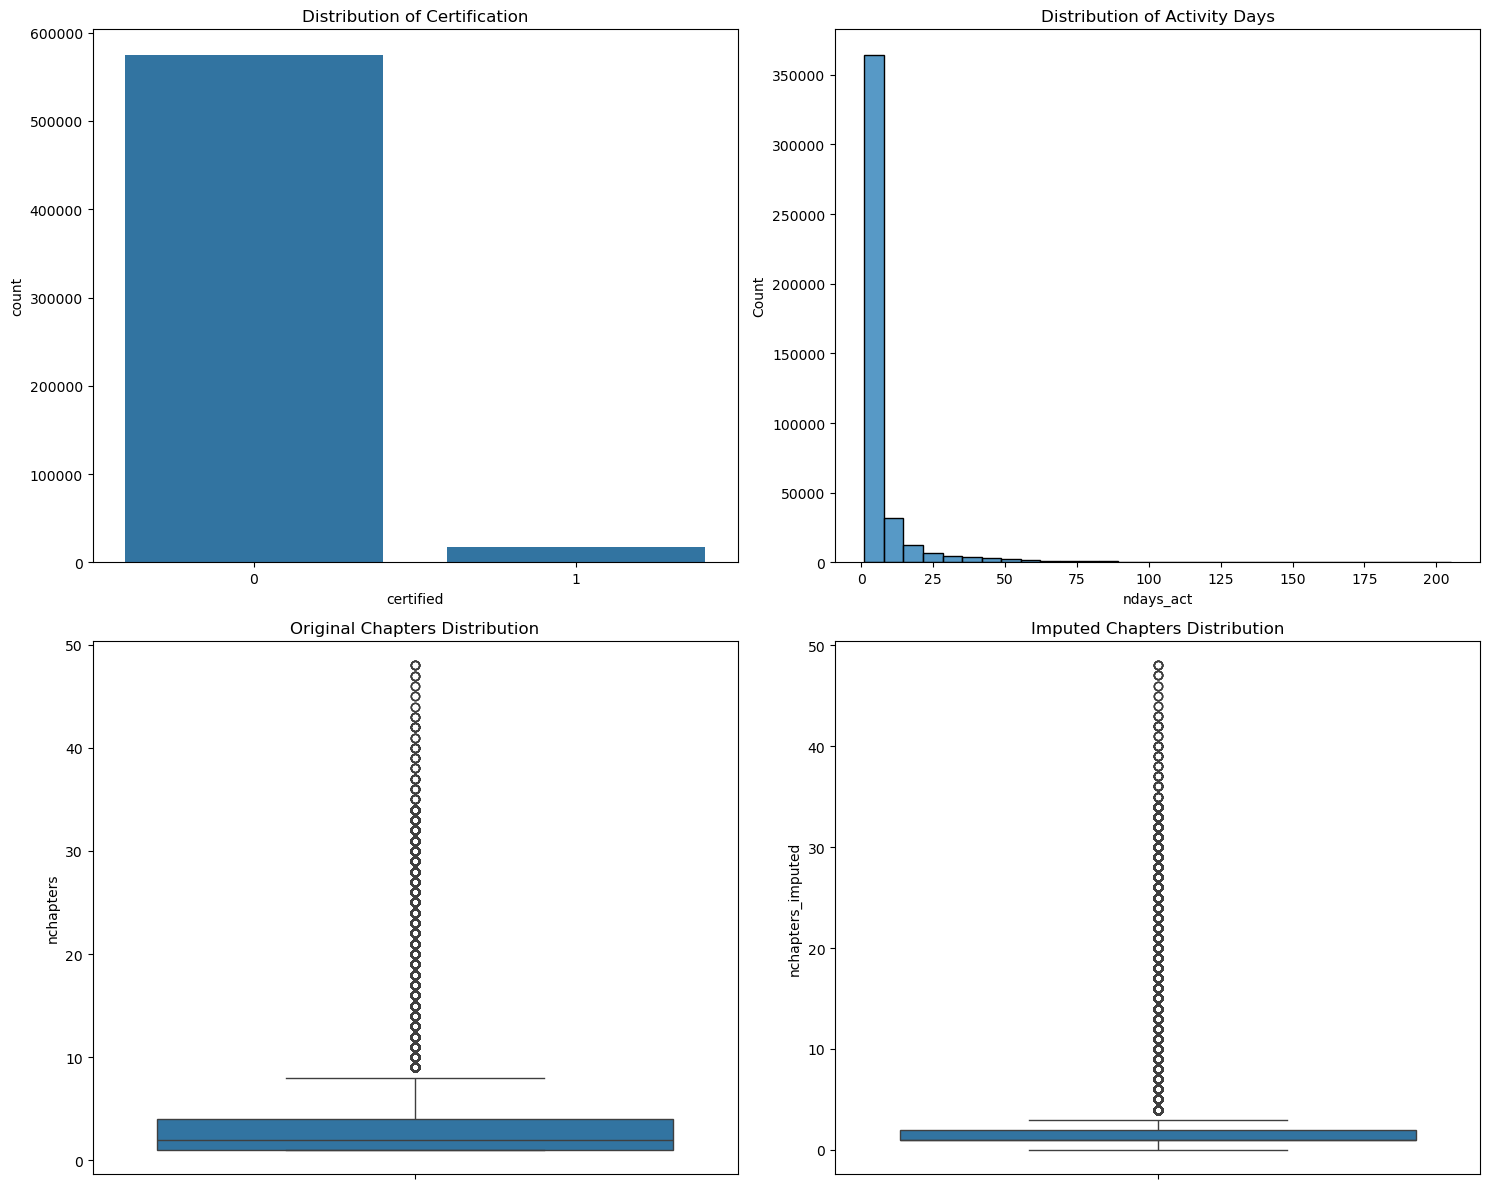

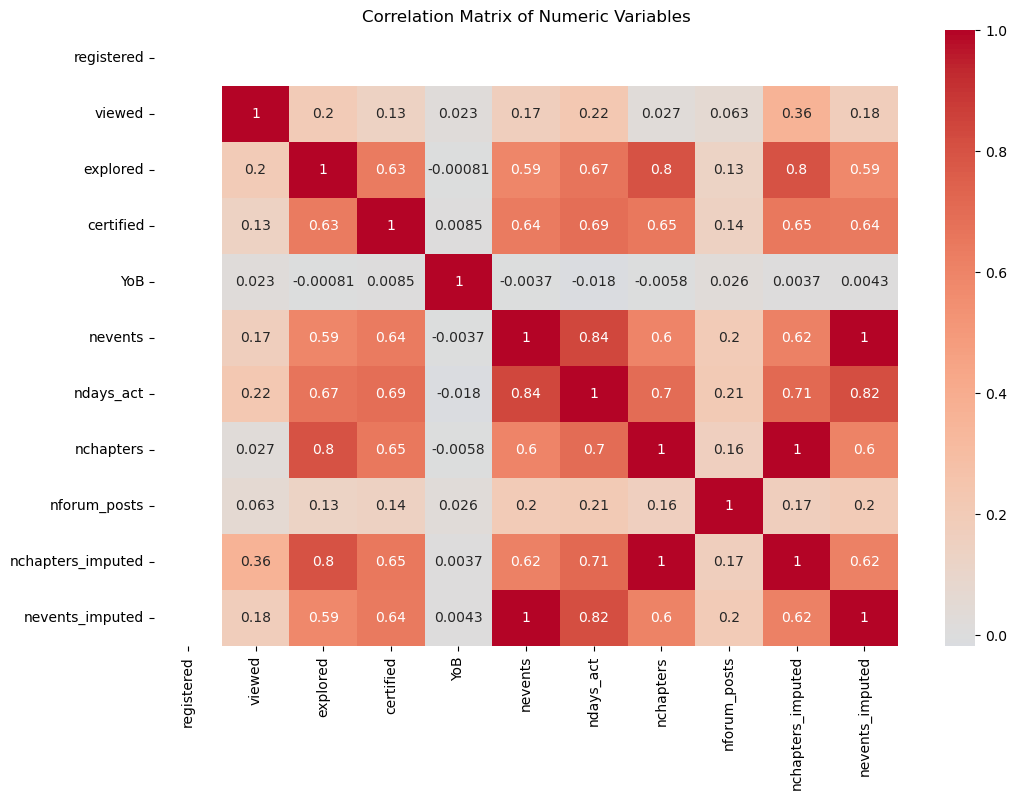

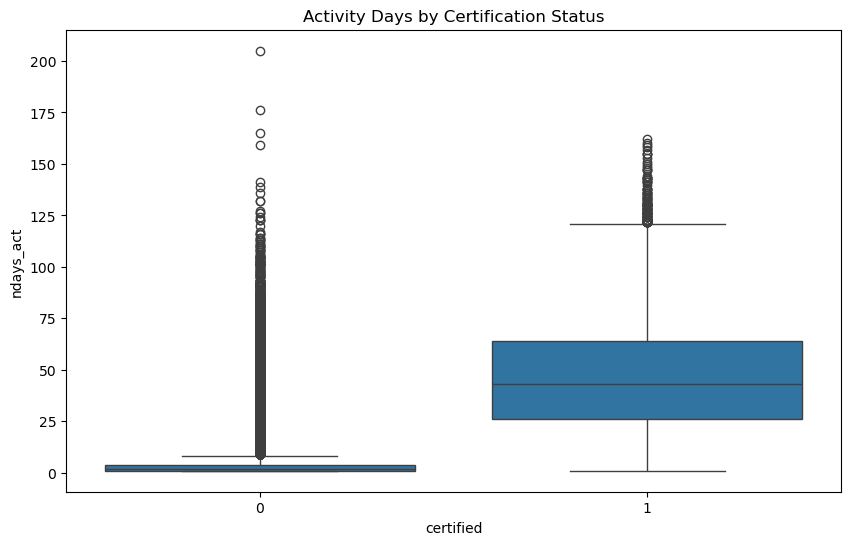


Key Statistics by Certification Status:
--------------------------------------------------
          ndays_act                nchapters_imputed         nevents          \
               mean median   count              mean median     mean  median   
certified                                                                      
0              4.21    2.0  418999              2.04    1.0   244.77    21.0   
1             46.91   43.0   17675             16.71   16.0  5163.27  4513.0   

          viewed explored  
            mean     mean  
certified                  
0           0.62     0.04  
1           1.00     0.96  


In [37]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Basic statistics and patterns
def perform_eda(df):
    # 1. Overall Dataset Info
    print("Dataset Overview:")
    print("-" * 50)
    print("\nShape:", df.shape)
    print("\nColumns:", df.columns.tolist())
    
    # 2. Missing Values Analysis
    print("\nMissing Values Analysis:")
    print("-" * 50)
    missing = df.isnull().sum()
    missing_pct = (missing / len(df)) * 100
    missing_info = pd.DataFrame({
        'Missing Values': missing,
        'Percentage': missing_pct
    }).sort_values('Percentage', ascending=False)
    print(missing_info[missing_info['Missing Values'] > 0])
    
    # 3. Key Variables Distribution
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # Certification Distribution
    sns.countplot(data=df, x='certified', ax=axes[0,0])
    axes[0,0].set_title('Distribution of Certification')
    
    # Activity Days Distribution
    sns.histplot(data=df, x='ndays_act', bins=30, ax=axes[0,1])
    axes[0,1].set_title('Distribution of Activity Days')
    
    # Chapters Distribution (Original vs Imputed)
    sns.boxplot(data=df, y='nchapters', ax=axes[1,0])
    axes[1,0].set_title('Original Chapters Distribution')
    
    sns.boxplot(data=df, y='nchapters_imputed', ax=axes[1,1])
    axes[1,1].set_title('Imputed Chapters Distribution')
    
    plt.tight_layout()
    plt.show()
    
    # 4. Correlation Analysis
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    correlation = df[numeric_cols].corr()
    
    plt.figure(figsize=(12, 8))
    sns.heatmap(correlation, annot=True, cmap='coolwarm', center=0)
    plt.title('Correlation Matrix of Numeric Variables')
    plt.show()
    
    # 5. Activity Patterns
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='certified', y='ndays_act', data=df)
    plt.title('Activity Days by Certification Status')
    plt.show()
    
    # 6. Key Statistics by Certification
    print("\nKey Statistics by Certification Status:")
    print("-" * 50)
    print(df.groupby('certified').agg({
        'ndays_act': ['mean', 'median', 'count'],
        'nchapters_imputed': ['mean', 'median'],
        'nevents': ['mean', 'median'],
        'viewed': 'mean',
        'explored': 'mean'
    }).round(2))

# Run EDA
perform_eda(df_cleaned)


In [6]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split

# 1. Read the dataset
df = pd.read_csv('cleaned_dataset.csv')

# 2. Check data types
print("Initial data types:")
print(df.dtypes)

# 3. Convert data types and clean the data
def clean_and_convert_data(df):
    # Make a copy to avoid modifying the original
    df = df.copy()
    
    # Convert viewed, explored, certified to numeric
    df['viewed'] = pd.to_numeric(df['viewed'], errors='coerce').fillna(0).astype(int)
    df['explored'] = pd.to_numeric(df['explored'], errors='coerce').fillna(0).astype(int)
    df['certified'] = pd.to_numeric(df['certified'], errors='coerce').fillna(0).astype(int)
    
    # Convert grade to numeric, handling any non-numeric values
    df['grade'] = pd.to_numeric(df['grade'], errors='coerce').fillna(0)
    
    # Ensure userid_DI and course_id are strings (if they should be)
    df['userid_DI'] = df['userid_DI'].astype(str)
    df['course_id'] = df['course_id'].astype(str)
    
    return df

# Clean the data
df = clean_and_convert_data(df)

# 4. Verify the conversion
print("\nData types after conversion:")
print(df.dtypes)

# 5. Check for any remaining issues
print("\nSample of cleaned data:")
print(df.head())

# 6. Check for any null values
print("\nNull values in each column:")
print(df.isnull().sum())

# Now we can create the interaction score
def create_interaction_score(row):
    score = 0
    # Now these operations should work because all values are numeric
    if row['viewed'] == 1:
        score += 1
    if row['explored'] == 1:
        score += 2
    if row['certified'] == 1:
        score += 3
    if row['grade'] > 0:
        score += row['grade'] / 100 * 4
    return score

# Test the interaction score calculation
df['interaction_score'] = df.apply(create_interaction_score, axis=1)

# Verify the interaction scores
print("\nSample of interaction scores:")
print(df[['userid_DI', 'course_id', 'viewed', 'explored', 'certified', 'grade', 'interaction_score']].head())

# Create the user-course matrix
user_course_matrix = df.pivot_table(
    index='userid_DI',
    columns='course_id',
    values='interaction_score',
    fill_value=0
)

print("\nShape of user-course matrix:", user_course_matrix.shape)
print("\nSample of user-course matrix:")
print(user_course_matrix.head())


Initial data types:
course_id             object
userid_DI             object
registered             int64
viewed                 int64
explored               int64
certified              int64
final_cc_cname_DI     object
LoE_DI                object
YoB                  float64
gender                object
grade                 object
start_time_DI         object
last_event_DI         object
nevents              float64
ndays_act            float64
nchapters            float64
nforum_posts           int64
nchapters_imputed    float64
nevents_imputed      float64
dtype: object

Data types after conversion:
course_id             object
userid_DI             object
registered             int64
viewed                 int32
explored               int32
certified              int32
final_cc_cname_DI     object
LoE_DI                object
YoB                  float64
gender                object
grade                float64
start_time_DI         object
last_event_DI         object
nevents 

In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set plot style for better visuals
sns.set(style='whitegrid')

# Load the dataset
df = pd.read_csv('cleaned_dataset.csv') 

# Display the first few rows
print("First few rows of the dataset:")
display(df.head())

# Get basic information about the dataset
print("\nDataset Information:")
print(df.info())

# Check for missing values
print("\nMissing values in each column:")
print(df.isnull().sum())

# Summary statistics for numerical columns
print("\nSummary statistics for numerical columns:")
display(df.describe())

# Handle missing values if necessary
# For example, fill missing grades with the mean grade
# df['grade'].fillna(df['grade'].mean(), inplace=True)

# Data type conversions if necessary
# For example, ensure 'registered' is treated as categorical
categorical_cols = ['registered', 'viewed', 'explored', 'certified', 'gender']

for col in categorical_cols:
    df[col] = df[col].astype('category')

# Visualize the distribution of categorical variables
for col in categorical_cols:
    plt.figure(figsize=(6, 4))
    sns.countplot(x=col, data=df)
    plt.title(f'Count of {col}')
    plt.show()

# Visualize the distribution of numerical variables
numerical_cols = ['grade', 'ndays_act', 'nforum_posts', 'nchapters_imputed', 'nevents_imputed']

for col in numerical_cols:
    plt.figure(figsize=(8, 4))
    sns.histplot(df[col], bins=30, kde=True)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.show()

# Boxplots to identify outliers in numerical variables
for col in numerical_cols:
    plt.figure(figsize=(6, 4))
    sns.boxplot(x=df[col])
    plt.title(f'Boxplot of {col}')
    plt.show()

# Correlation matrix to explore relationships between numerical variables
plt.figure(figsize=(10, 8))
corr_matrix = df[numerical_cols].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix of Numerical Variables')
plt.show()

# Analyze 'grade' in relation to 'gender' and 'LoE_DI' (Level of Education)
plt.figure(figsize=(8, 6))
sns.boxplot(x='gender', y='grade', data=df)
plt.title('Grade Distribution by Gender')
plt.show()

plt.figure(figsize=(12, 6))
sns.boxplot(x='LoE_DI', y='grade', data=df)
plt.title('Grade Distribution by Level of Education')
plt.xticks(rotation=45)
plt.show()

# Analyze enrollment status across countries
plt.figure(figsize=(12, 6))
top_countries = df['final_cc_cname_DI'].value_counts().nlargest(10).index
sns.countplot(y='final_cc_cname_DI', data=df[df['final_cc_cname_DI'].isin(top_countries)], order=top_countries)
plt.title('Top 10 Countries by Enrollment')
plt.xlabel('Number of Enrollments')
plt.ylabel('Country')
plt.show()

# Relationship between activity and certification
plt.figure(figsize=(8, 6))
sns.boxplot(x='certified', y='ndays_act', data=df)
plt.title('Number of Active Days vs. Certification Status')
plt.show()

# Pairplot for numerical variables

First few rows of the dataset:


,course_id,userid_DI,registered,viewed,explored,certified,final_cc_cname_DI,LoE_DI,YoB,gender,grade,start_time_DI,last_event_DI,nevents,ndays_act,nchapters,nforum_posts,nchapters_imputed,nevents_imputed
0,HarvardX/CB22x/2013_Spring,MHxPC130442623,1,0,0,0,United States,Bachelor's,1988.0,m,0,2012-12-19,2013-11-17,NaN,9.0,NaN,0,3.0,3.0
1,HarvardX/CS50x/2012,MHxPC130442623,1,1,0,0,United States,Bachelor's,1988.0,m,0,2012-10-15,NaN,NaN,9.0,1.0,0,1.0,1.0
2,HarvardX/CB22x/2013_Spring,MHxPC130275857,1,0,0,0,United States,Bachelor's,1988.0,m,0,2013-02-08,2013-11-17,NaN,16.0,NaN,0,3.0,4.0
3,HarvardX/CS50x/2012,MHxPC130275857,1,0,0,0,United States,Bachelor's,1988.0,m,0,2012-09-17,NaN,NaN,16.0,NaN,0,3.0,3.0
4,HarvardX/ER22x/2013_Spring,MHxPC130275857,1,0,0,0,United States,Bachelor's,1988.0,f,0,2012-12-19,NaN,NaN,16.0,NaN,0,3.0,2.0



Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 592766 entries, 0 to 592765
Data columns (total 19 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   course_id          592766 non-null  object 
 1   userid_DI          592766 non-null  object 
 2   registered         592766 non-null  int64  
 3   viewed             592766 non-null  int64  
 4   explored           592766 non-null  int64  
 5   certified          592766 non-null  int64  
 6   final_cc_cname_DI  592766 non-null  object 
 7   LoE_DI             592766 non-null  object 
 8   YoB                592766 non-null  float64
 9   gender             592766 non-null  object 
 10  grade              592766 non-null  object 
 11  start_time_DI      592766 non-null  object 
 12  last_event_DI      422863 non-null  object 
 13  nevents            404323 non-null  float64
 14  ndays_act          436674 non-null  float64
 15  nchapters          355995 non

,registered,viewed,explored,certified,YoB,nevents,ndays_act,nchapters,nforum_posts,nchapters_imputed,nevents_imputed
count,592766.0,592766.000000,592766.000000,592766.000000,592766.000000,404323.000000,436674.000000,355995.000000,592766.000000,592766.000000,592766.000000
mean,1.0,0.631195,0.065592,0.029838,1985.637746,459.783658,5.940519,3.689291,0.019660,2.482610,314.267035
std,0.0,0.482481,0.247569,0.170141,8.254398,1576.711332,12.263307,4.568059,0.234847,3.856483,1319.520614
min,1.0,0.000000,0.000000,0.000000,1931.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000
25%,1.0,0.000000,0.000000,0.000000,1983.000000,3.000000,1.000000,1.000000,0.000000,1.000000,2.000000
50%,1.0,1.000000,0.000000,0.000000,1988.000000,25.000000,2.000000,2.000000,0.000000,1.000000,4.000000
75%,1.0,1.000000,0.000000,0.000000,1991.000000,169.000000,5.000000,4.000000,0.000000,2.000000,68.000000
max,1.0,1.000000,1.000000,1.000000,2013.000000,197757.000000,205.000000,48.000000,20.000000,48.000000,197757.000000


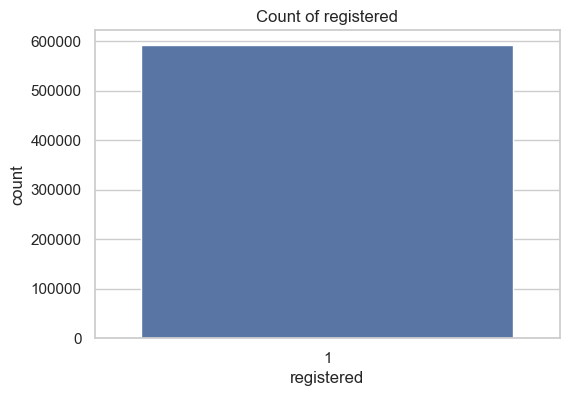

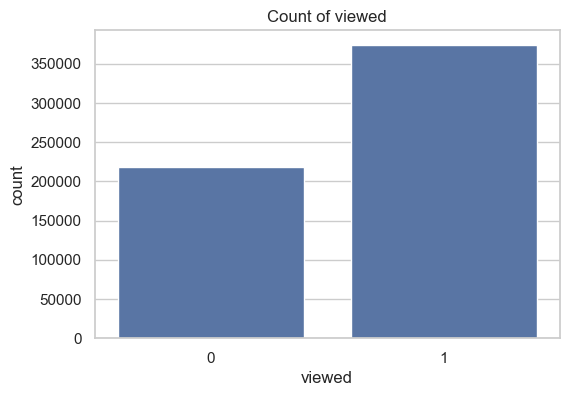

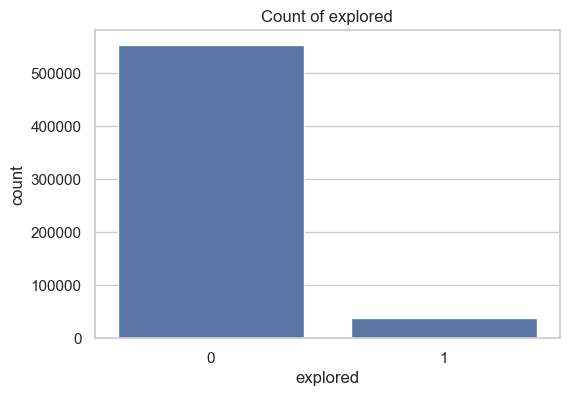

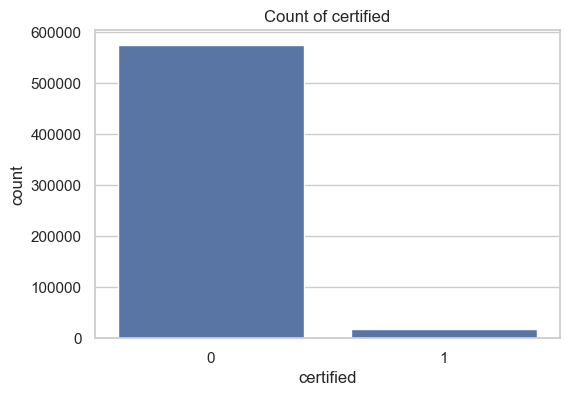

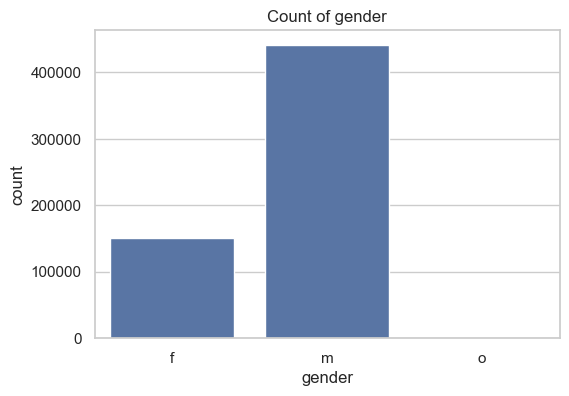

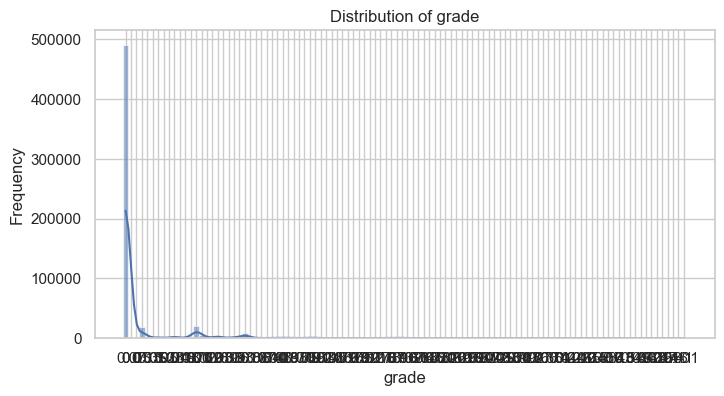

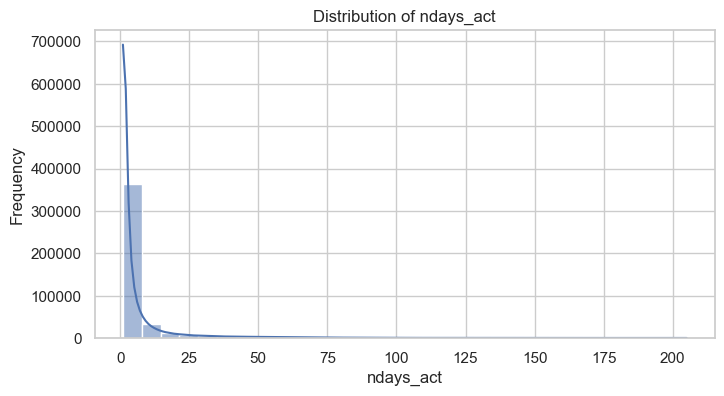

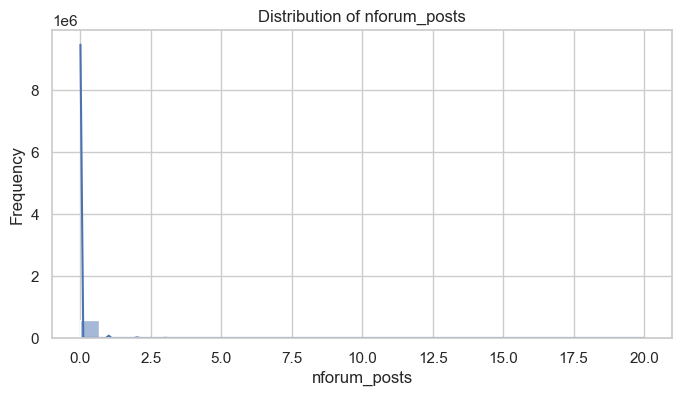

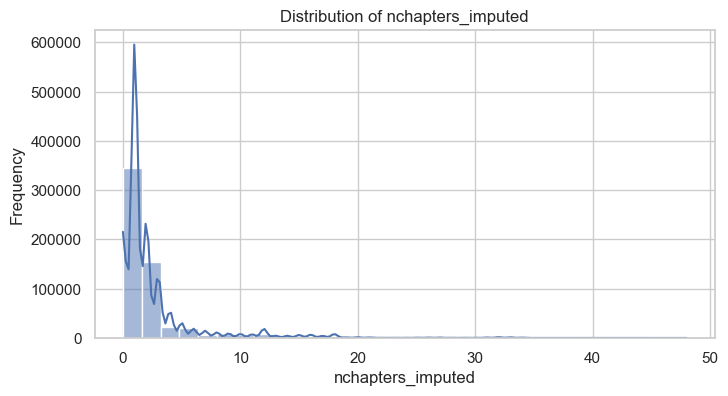

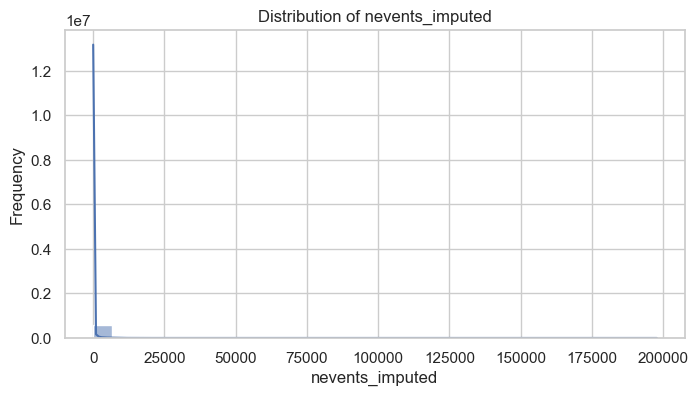

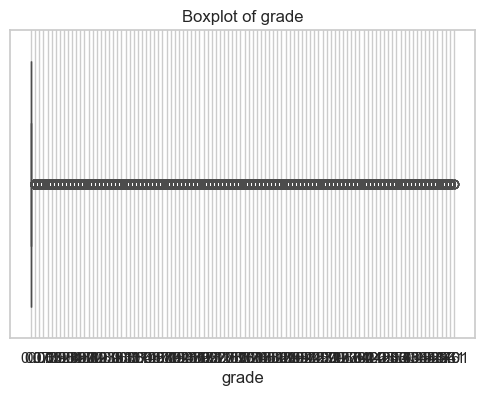

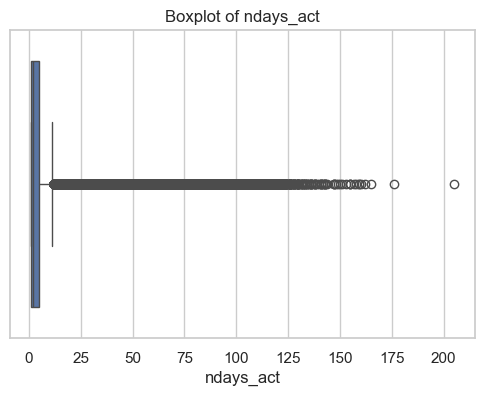

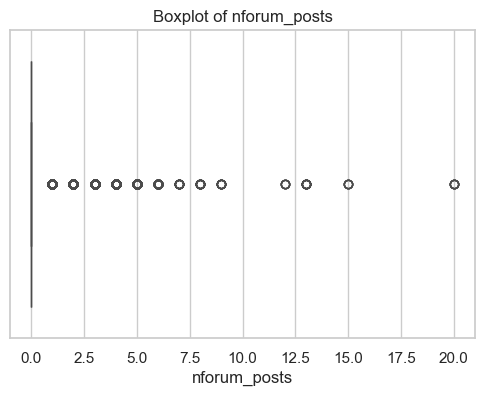

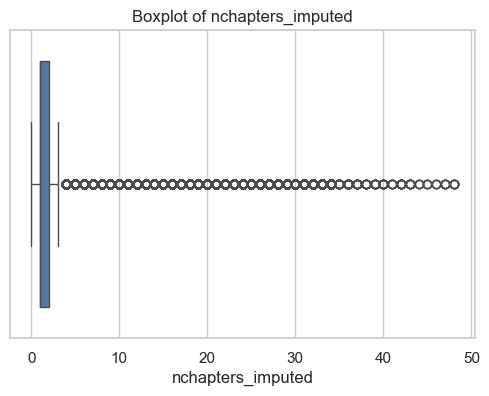

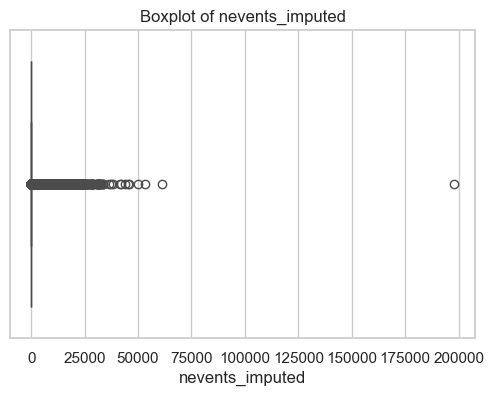

ValueError: could not convert string to float: ' '

<Figure size 1000x800 with 0 Axes>

In [9]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set plot style for better visuals
#ns.set(style='whitegrid')

# Load the dataset
df = pd.read_csv('cleaned_dataset.csv')  

# Display the first few rows
print("First few rows of the dataset:")
display(df.head())

# Get basic information about the dataset
print("\nDataset Information:")
print(df.info())

# Check for missing values
print("\nMissing values in each column:")
print(df.isnull().sum())

# Summary statistics for numerical columns
print("\nSummary statistics for numerical columns:")
display(df.describe())

# Handle missing values if necessary
# For example, fill missing grades with the mean grade
# df['grade'].fillna(df['grade'].mean(), inplace=True)

# Data type conversions if necessary
# For example, ensure 'registered' is treated as categorical
categorical_cols = ['registered', 'viewed', 'explored', 'certified', 'gender']

for col in categorical_cols:
    df[col] = df[col].astype('category')

# Visualize the distribution of categorical variables
for col in categorical_cols:
    plt.figure(figsize=(6, 4))
    sns.countplot(x=col, data=df)
    plt.title(f'Count of {col}')
    plt.show()

# Visualize the distribution of numerical variables
numerical_cols = ['grade', 'ndays_act', 'nforum_posts', 'nchapters_imputed', 'nevents_imputed']

for col in numerical_cols:
    plt.figure(figsize=(8, 4))
    sns.histplot(df[col], bins=30, kde=True)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.show()

# Boxplots to identify outliers in numerical variables
for col in numerical_cols:
    plt.figure(figsize=(6, 4))
    sns.boxplot(x=df[col])
    plt.title(f'Boxplot of {col}')
    plt.show()

# Correlation matrix to explore relationships between numerical variables
plt.figure(figsize=(10, 8))
corr_matrix = df[numerical_cols].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix of Numerical Variables')
plt.show()

# Analyze 'grade' in relation to 'gender' and 'LoE_DI' (Level of Education)
plt.figure(figsize=(8, 6))
sns.boxplot(x='gender', y='grade', data=df)
plt.title('Grade Distribution by Gender')
plt.show()

plt.figure(figsize=(12, 6))
sns.boxplot(x='LoE_DI', y='grade', data=df)
plt.title('Grade Distribution by Level of Education')
plt.xticks(rotation=45)
plt.show()

# Analyze enrollment status across countries
plt.figure(figsize=(12, 6))
top_countries = df['final_cc_cname_DI'].value_counts().nlargest(10).index
sns.countplot(y='final_cc_cname_DI', data=df[df['final_cc_cname_DI'].isin(top_countries)], order=top_countries)
plt.title('Top 10 Countries by Enrollment')
plt.xlabel('Number of Enrollments')
plt.ylabel('Country')
plt.show()

# Relationship between activity and certification
plt.figure(figsize=(8, 6))
sns.boxplot(x='certified', y='ndays_act', data=df)
plt.title('Number of Active Days vs. Certification Status')
plt.show()

# Pairplot for numerical variables
sns.pairplot(df[numerical_cols])
plt.show()


In [5]:
# Assuming df is your DataFrame
status_columns = ['registered', 'viewed', 'explored', 'certified']

# Initialize an empty dictionary to store counts
status_counts = {}

# Loop through each status column and count the occurrences
for col in status_columns:
    counts = df[col].value_counts().sort_index()
    status_counts[col] = counts

# Display the counts
for col, counts in status_counts.items():
    print(f"\nCounts for '{col}':")
    print(counts)



Counts for 'registered':
registered
1    592766
Name: count, dtype: int64

Counts for 'viewed':
viewed
0    218615
1    374151
Name: count, dtype: int64

Counts for 'explored':
explored
0    553885
1     38881
Name: count, dtype: int64

Counts for 'certified':
certified
0    575079
1     17687
Name: count, dtype: int64
